In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector, StrVector
from rpy2.robjects import DataFrame, IntVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [261]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
df = dfs.copy()

print(df.shape)
print()
print(df.info())
print()
df.head(3)


(1678, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB
None



,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [262]:
# %%writefile check_value_counts.py
def check_value_counts(df):
    for col in df.select_dtypes(include=['category', 'object']).columns:
        print(f"{col}: {df[col].value_counts().to_dict()}\n")

check_value_counts(df)

subject_id: {'P01001': 1, '17067': 1, '17039': 1, '17038': 1, '17037': 1, '17036': 1, '17035': 1, '17034': 1, '17033': 1, '17032': 1, '17031': 1, '17030': 1, '17029': 1, '17028': 1, '17027': 1, '17026': 1, '17025': 1, '17024': 1, '17023': 1, '17022': 1, '17021': 1, '17020': 1, '17019': 1, '17018': 1, '17017': 1, '17040': 1, '17041': 1, '17042': 1, '17055': 1, '17065': 1, '17064': 1, '17063': 1, '17062': 1, '17061': 1, '17060': 1, '17059': 1, '17058': 1, '17057': 1, '17056': 1, '17054': 1, '17043': 1, '17053': 1, '17052': 1, '17051': 1, '17050': 1, '17049': 1, '17048': 1, '17047': 1, '17046': 1, '17045': 1, '17044': 1, '17016': 1, '17015': 1, '17014': 1, '16120': 1, '16130': 1, '16129': 1, '16128': 1, '16127': 1, '16126': 1, '16125': 1, '16124': 1, '16123': 1, '16122': 1, '16121': 1, '16119': 1, '16132': 1, '16118': 1, '16117': 1, '16116': 1, '16115': 1, '16114': 1, '16113': 1, '16112': 1, '16111': 1, '16110': 1, '16109': 1, '16131': 1, '16133': 1, '17013': 1, '17002': 1, '17012': 1, '1

In [263]:
df = df[df['Expt'] != 'riluzole']
# print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
# print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

# df.shape

In [264]:
# df_time_var = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
# df_time_var.describe()
# df_time.isna().sum()

In [265]:
# %%writefile log_transform_columns.py
def log_transform_columns(df, cols):
    for col in cols:
        df[col + "_l"] = np.log1p(df[col])  # ln(1 + x)
    return df
df = log_transform_columns(df, ['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity'])
df

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729
3,P01004,0.0,99.0,Male,Limb,Active,1,47.192334,9.428384,28.428384,-5.956706,lica,licals,3.381960,2.344531,4.605170
4,P01005,0.0,108.0,Male,Bulbar,Placebo,1,71.307324,19.726347,38.726347,-5.058994,lica,licals,3.682015,3.031406,4.691348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,1-63622,1.0,106.0,M,Limb,Placebo,1,53.947000,4.728000,27.598055,-4.592068,miro,mirocals,3.353339,1.745366,4.672829
392,1-63625,1.0,81.0,M,Limb,IL2,1,59.247000,10.740000,26.970365,-3.441551,miro,mirocals,3.331146,2.463002,4.406719
393,1-63777,1.0,109.0,F,Limb,Placebo,1,62.620000,11.364000,22.075968,-3.870232,miro,mirocals,3.138792,2.514789,4.700480
394,1-63778,0.0,86.0,M,Limb,Placebo,1,59.948000,5.712000,30.648967,-5.597218,miro,mirocals,3.454706,1.903897,4.465908


In [266]:
# %%writefile make_columns_object.py
def make_columns_object(df, cols):
    for col in cols:
        df[col] = df[col].astype('object')
    return df

df = make_columns_object(df, ['European', 'Event'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          396 non-null    object 
 1   Event               396 non-null    object 
 2   Vital_capacity      396 non-null    float64
 3   Sex                 396 non-null    object 
 4   Onset_site          396 non-null    object 
 5   Study_Arm           396 non-null    object 
 6   European            396 non-null    object 
 7   Age                 396 non-null    float64
 8   Diagnostic_Delay    396 non-null    float64
 9   Disease_Duration    396 non-null    float64
 10  TRICALS             396 non-null    float64
 11  Study_id            396 non-null    object 
 12  Expt                396 non-null    object 
 13  Disease_Duration_l  396 non-null    float64
 14  Diagnostic_Delay_l  396 non-null    float64
 15  Vital_capacity_l    396 non-null    float64
dtypes: float64(8)

In [267]:
# %%writefile standardize_column.py
def standardize_column(df):
    for col in df.select_dtypes(include=['float']).columns:
        df[col + '_std'] = (df[col] - df[col].mean()) / df[col].std()
    return df

df = standardize_column(df)
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821


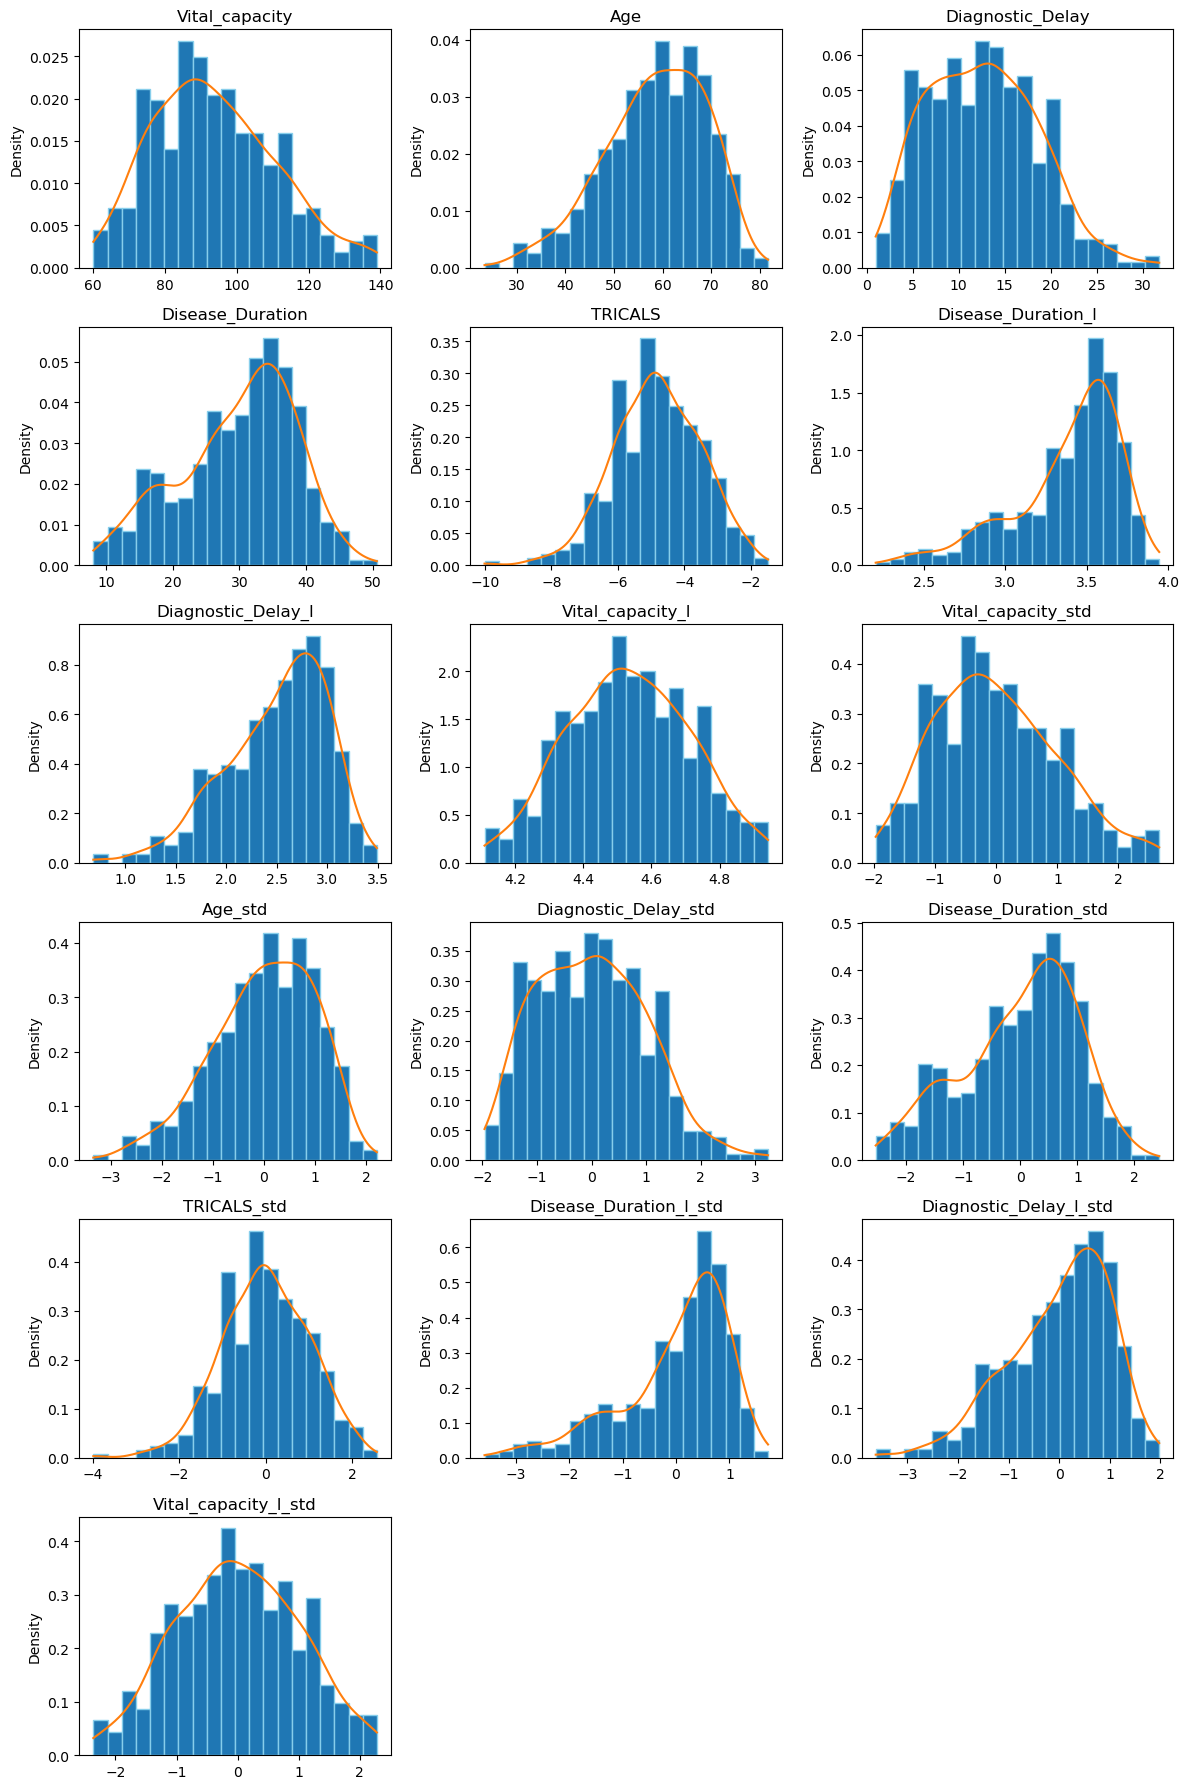

In [268]:
# %%writefile plot_histograms_with_kde.py
def plot_histograms_with_kde(df):

    # Plot histogram and density
    cols = df.select_dtypes(include=['float']).columns
    n_per_row = 3
    n_rows = int(np.ceil(len(cols) / n_per_row))

    fig, axes = plt.subplots(n_rows, n_per_row,
        figsize=(4 * n_per_row, 3 * n_rows)
    )

    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        data = df[col].dropna()

        ax.hist(data, bins=20, density=True, edgecolor='skyblue')

        kde = gaussian_kde(data)
        x = np.linspace(data.min(), data.max(), 300)
        ax.plot(x, kde(x))

        ax.set_title(col)
        ax.set_ylabel('Density')

    for ax in axes[len(cols):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_histograms_with_kde(df)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              396 non-null    object 
 1   Event                   396 non-null    object 
 2   Vital_capacity          396 non-null    float64
 3   Sex                     396 non-null    object 
 4   Onset_site              396 non-null    object 
 5   Study_Arm               396 non-null    object 
 6   European                396 non-null    object 
 7   Age                     396 non-null    float64
 8   Diagnostic_Delay        396 non-null    float64
 9   Disease_Duration        396 non-null    float64
 10  TRICALS                 396 non-null    float64
 11  Study_id                396 non-null    object 
 12  Expt                    396 non-null    object 
 13  Disease_Duration_l      396 non-null    float64
 14  Diagnostic_Delay_l      396 non-null    float64

In [270]:
check_value_counts(df)

subject_id: {'P01001': 1, '1-62527': 1, '1-62525': 1, '1-62523': 1, '1-62521': 1, '1-62519': 1, '1-63643': 1, '1-63642': 1, '1-63641': 1, '1-63640': 1, '1-63639': 1, '1-63638': 1, '1-65193': 1, '1-63259': 1, '1-63258': 1, '1-63257': 1, '1-63256': 1, '1-63254': 1, '1-63253': 1, '1-63251': 1, '1-63249': 1, '1-63248': 1, '1-63717': 1, '1-62526': 1, '1-62531': 1, '1-63498': 1, '1-62532': 1, '1-63845': 1, '1-63836': 1, '1-63839': 1, '1-63827': 1, '1-63842': 1, '1-63825': 1, '1-63847': 1, '1-63463': 1, '1-63462': 1, '1-63461': 1, '1-63460': 1, '1-63459': 1, '1-63457': 1, '1-63456': 1, '1-63455': 1, '1-62538': 1, '1-62537': 1, '1-62536': 1, '1-62535': 1, '1-62534': 1, '1-62533': 1, '1-63716': 1, '1-63714': 1, 'P01002': 1, '1-62555': 1, '1-62553': 1, '1-62552': 1, '1-62551': 1, '1-62550': 1, '1-62549': 1, '1-62548': 1, '1-62547': 1, '1-62546': 1, '1-62545': 1, '1-62544': 1, '1-62280': 1, '1-62276': 1, '1-62274': 1, '1-62273': 1, '1-62272': 1, '1-62270': 1, '1-62269': 1, '1-62266': 1, '1-62265'

In [271]:
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar', 'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 0, 'Non-European', 'European')

In [272]:
check_value_counts(df)

subject_id: {'P01001': 1, '1-62527': 1, '1-62525': 1, '1-62523': 1, '1-62521': 1, '1-62519': 1, '1-63643': 1, '1-63642': 1, '1-63641': 1, '1-63640': 1, '1-63639': 1, '1-63638': 1, '1-65193': 1, '1-63259': 1, '1-63258': 1, '1-63257': 1, '1-63256': 1, '1-63254': 1, '1-63253': 1, '1-63251': 1, '1-63249': 1, '1-63248': 1, '1-63717': 1, '1-62526': 1, '1-62531': 1, '1-63498': 1, '1-62532': 1, '1-63845': 1, '1-63836': 1, '1-63839': 1, '1-63827': 1, '1-63842': 1, '1-63825': 1, '1-63847': 1, '1-63463': 1, '1-63462': 1, '1-63461': 1, '1-63460': 1, '1-63459': 1, '1-63457': 1, '1-63456': 1, '1-63455': 1, '1-62538': 1, '1-62537': 1, '1-62536': 1, '1-62535': 1, '1-62534': 1, '1-62533': 1, '1-63716': 1, '1-63714': 1, 'P01002': 1, '1-62555': 1, '1-62553': 1, '1-62552': 1, '1-62551': 1, '1-62550': 1, '1-62549': 1, '1-62548': 1, '1-62547': 1, '1-62546': 1, '1-62545': 1, '1-62544': 1, '1-62280': 1, '1-62276': 1, '1-62274': 1, '1-62273': 1, '1-62272': 1, '1-62270': 1, '1-62269': 1, '1-62266': 1, '1-62265'

In [273]:
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std
0,P01001,0.0,107.0,Male,Limb,Placebo,European,54.762491,13.600526,32.600526,-4.921357,lica,licals,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441
1,P01002,1.0,99.0,Female,Limb,Placebo,European,61.160849,20.137976,41.538765,-6.347018,lica,licals,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812
2,P01003,0.0,102.0,Male,Limb,Active,European,46.702259,15.571616,34.571616,-6.373852,lica,licals,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821


In [274]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,True,False,True,True,False
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,True,False,False,True,False


In [275]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals'],
      dtype='object')

In [276]:
cols = ['Onset_site_Limb', 'European_Non-European', 'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals']

# Convert one-hot encoded columns to int
for col in cols:
    df_onehot[col] = df_onehot[col].astype(int)

df_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,0,1,1,0
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,0,0,1,0
2,P01003,0.0,102.0,46.702259,15.571616,34.571616,-6.373852,lica,3.571548,2.807691,4.634729,0.493296,-1.123785,0.501152,0.559956,-1.189109,0.586210,0.616453,0.563821,1,0,1,0,0


In [277]:
# Create interactions
df_onehot['Sex_onset'] = df_onehot['Sex_Male']*df_onehot['Onset_site_Limb']
df_onehot['Age_Sex'] = df_onehot['Sex_Male']*df_onehot['Age_std']
df_onehot['Age_onset'] = df_onehot['Age_std']*df_onehot['Onset_site_Limb']
df_onehot['Age_TRICALS'] = df_onehot['Age_std']*df_onehot['TRICALS_std']
# df_onehot['Trical : Placebo Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

# df_onehot.info()
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Disease_Duration_l,Diagnostic_Delay_l,Vital_capacity_l,Vital_capacity_std,Age_std,Diagnostic_Delay_std,Disease_Duration_std,TRICALS_std,Disease_Duration_l_std,Diagnostic_Delay_l_std,Vital_capacity_l_std,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,3.514542,2.681058,4.682131,0.787136,-0.355001,0.168722,0.329936,-0.075830,0.412636,0.363265,0.828441,1,0,1,1,0,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,99.0,61.160849,20.137976,41.538765,-6.347018,lica,3.750416,3.051071,4.605170,0.316991,0.255274,1.271281,1.373002,-1.168542,1.130829,1.103061,0.398812,1,0,0,1,0,0,0.000000,0.255274,-0.298299


In [278]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 395
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              396 non-null    object 
 1   Event                   396 non-null    object 
 2   Vital_capacity          396 non-null    float64
 3   Age                     396 non-null    float64
 4   Diagnostic_Delay        396 non-null    float64
 5   Disease_Duration        396 non-null    float64
 6   TRICALS                 396 non-null    float64
 7   Study_id                396 non-null    object 
 8   Disease_Duration_l      396 non-null    float64
 9   Diagnostic_Delay_l      396 non-null    float64
 10  Vital_capacity_l        396 non-null    float64
 11  Vital_capacity_std      396 non-null    float64
 12  Age_std                 396 non-null    float64
 13  Diagnostic_Delay_std    396 non-null    float64
 14  Disease_Duration_std    396 non-null    float64

In [279]:
df1 = df_onehot.copy()

In [280]:
df1.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Disease_Duration_l',
       'Diagnostic_Delay_l', 'Vital_capacity_l', 'Vital_capacity_std',
       'Age_std', 'Diagnostic_Delay_std', 'Disease_Duration_std',
       'TRICALS_std', 'Disease_Duration_l_std', 'Diagnostic_Delay_l_std',
       'Vital_capacity_l_std', 'Onset_site_Limb', 'European_Non-European',
       'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [281]:
df1 = df1[['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id', 'Study_Arm_Placebo',
       'Age_std', 'TRICALS_std', 'Diagnostic_Delay_l_std', 'Vital_capacity_l_std', 'Onset_site_Limb', 
       'European_Non-European', 'Sex_Male',
       'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

df1 = df1.rename(columns={'Age_std': 'Age',
                        'Vital_capacity_l_std': 'Vital_capacity',
                        'Diagnostic_Delay_l_std': 'Diagnostic_Delay',
                        'TRICALS_std': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb',
                        'Sex_Male': 'Sex_Male'
                        })

df1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id',
       'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'European_Yes', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [282]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,European_Yes,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0.0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828441,1,0,1,1,-0.355001,-0.355001,0.026920
1,P01002,1.0,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.398812,1,0,0,0,0.000000,0.255274,-0.298299
2,P01003,0.0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.563821,1,0,1,1,-1.123785,-1.123785,1.336303


In [283]:
# df1.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/processed_data_for_flexible_parametric_model.csv', index=False)

In [284]:
# Train / Test split
print(df1.shape)

# Separate features from survival info
X = df1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df1['Disease_Duration']
y_event = df1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.25, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

len(train_df), len(test_df)

(396, 17)


(297, 99)

In [285]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 274 to 122
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         297 non-null    object 
 1   Expt_mirocals      297 non-null    int64  
 2   Study_id           297 non-null    object 
 3   Study_Arm_Placebo  297 non-null    int64  
 4   Age                297 non-null    float64
 5   TRICALS            297 non-null    float64
 6   Diagnostic_Delay   297 non-null    float64
 7   Vital_capacity     297 non-null    float64
 8   Onset_Limb         297 non-null    int64  
 9   European_Yes       297 non-null    int64  
 10  Sex_Male           297 non-null    int64  
 11  Sex_onset          297 non-null    int64  
 12  Age_Sex            297 non-null    float64
 13  Age_onset          297 non-null    float64
 14  Age_TRICALS        297 non-null    float64
 15  Disease_Duration   297 non-null    float64
 16  Event              297 non-nu

In [286]:
# %%writefile prepare_for_r.py
def make_columns_int(df):
    df = df.copy()
    df["Event"] = df["Event"].fillna(0).astype(int)
    return df

train_df = make_columns_int(train_df)
test_df = make_columns_int(test_df)

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_61288/3302243704.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Event"] = df["Event"].fillna(0).astype(int)
/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_61288/3302243704.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Event"] = df["Event"].fillna(0).astype(int)


In [287]:
with conversion.localconverter(pandas2ri.converter):
    r_df_train = pandas2ri.py2rpy(train_df)

with conversion.localconverter(pandas2ri.converter):
    r_df_test = pandas2ri.py2rpy(test_df)

# with conversion.localconverter(pandas2ri.converter):
#     r_df = pandas2ri.py2rpy(df1)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [288]:
# Candidate covariates (modify for your dataset)
covariates = [
   'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS','Expt_mirocals'
    ]

df_candidates = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [289]:
# %%writefile flex_parametric_model_cv_aic_for_model.py
def flex_parametric_model_cv_aic_for_model(df_python, vars_list, spline_df, n_splits=5):
    """
    Compute mean cross-validated AIC for a given variable set and spline df
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aics = []

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    for train_idx, test_idx in kf.split(df_python):
        train_df = df_python.iloc[train_idx]

        # Convert fold to R
        with localconverter(default_converter + pandas2ri.converter):
            r_train = pandas2ri.py2rpy(train_df)

        try:
            model = rstpm2.stpm2(formula, data=r_train, df=spline_df)
            aic = stats.AIC(model)[0]
            aics.append(aic)
        except Exception:
            aics.append(np.inf)

    return np.mean(aics)


In [290]:
# %%writefile perform_flex_parametric_model_cv_aic_for_model.py
def perform_flex_parametric_model_cv_aic_for_model(train_df, n_splits):

    n_splits = n_splits

    current_vars = covariates.copy()
    best_score = np.inf
    best_vars = current_vars
    best_df = None

    while True:
        candidates = []

        # Try current model with different dfs
        for df_spline in df_candidates:
            score = flex_parametric_model_cv_aic_for_model(train_df, current_vars, df_spline, n_splits)
            candidates.append((score, current_vars, df_spline))

        # Try removing each variable
        for var in current_vars:
            test_vars = [v for v in current_vars if v != var]
            for df_spline in df_candidates:
                score = flex_parametric_model_cv_aic_for_model(train_df, test_vars, df_spline, n_splits)
                candidates.append((score, test_vars, df_spline))

        # Pick best candidate
        best_candidate = min(candidates, key=lambda x: x[0])

        cand_score, cand_vars, cand_df = best_candidate

        # Stop if no improvement
        if cand_score >= best_score:
            break

        best_score = cand_score
        best_vars = cand_vars
        best_df = cand_df
        current_vars = cand_vars

    print("\n Selected model by CV-AIC:")
    print("Variables:", best_vars)
    print("Spline df:", best_df)
    print("CV-AIC:", best_score)

perform_flex_parametric_model_cv_aic_for_model(train_df=train_df, n_splits=5)


 Selected model by CV-AIC:
Variables: ['Age', 'TRICALS', 'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Expt_mirocals']
Spline df: 3
CV-AIC: 717.1084487725691


### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [291]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb  + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
# print(ro.r.summary(fp_model))

In [292]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
# print(ro.r.summary(fp_model))

In [293]:
# %%writefile extract_coefficients_from_fp_model_log_haz_scale.py
def extract_coefficients_from_fp_model_log_haz_scale(fp_model):
    # Get coefficients directly
    summary = ro.r.summary(fp_model)

    # Try using slotNames to see what's available
    print("Available slots:", ro.r.slotNames(summary))

    # Extract using the correct slot name (usually 'coef' or 'coefficients')
    coefficients = summary.slots['coef']

    # Convert to pandas DataFrame
    df_coef = pd.DataFrame(
        np.array(coefficients),
        columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
        index=list(coefficients.rownames)
    )

    df_coef = df_coef.iloc[1: -1]
    df_coef = df_coef.reset_index().rename(columns={"index": "Variable"})

    #--------------------------------------
    z = 1.96  # 95% CI

    df_coef["LHR"] = (df_coef["Estimate"])
    df_coef["CI_lower"] = (df_coef["Estimate"] - z * df_coef["Std. Error"])
    df_coef["CI_upper"] = (df_coef["Estimate"] + z * df_coef["Std. Error"])
    df_coef['Significant'] = df_coef['Pr(z)'] < 0.05

    return df_coef
extract_coefficients_from_fp_model_log_haz_scale(fp_model)

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),LHR,CI_lower,CI_upper,Significant
0,Age,-0.451557,0.125915,-3.586199,3.355328e-04,-0.451557,-0.698351,-0.204763,True
1,Sex_Male,0.789987,0.387467,2.038853,4.146470e-02,0.789987,0.030553,1.549422,True
2,Onset_Limb,0.904501,0.320842,2.819149,4.815113e-03,0.904501,0.275651,1.533352,True
3,TRICALS,3.192837,0.236680,13.490123,1.788012e-41,3.192837,2.728945,3.656730,True
4,Sex_onset,-1.107842,0.440333,-2.515917,1.187233e-02,-1.107842,-1.970896,-0.244789,True
5,Expt_mirocals,-0.263275,0.232929,-1.130280,2.583584e-01,-0.263275,-0.719816,0.193266,False
6,Diagnostic_Delay,0.173148,0.135621,1.276712,2.017038e-01,0.173148,-0.092668,0.438965,False
7,Study_Arm_Placebo,0.202307,0.184363,1.097334,2.724955e-01,0.202307,-0.159043,0.563658,False


In [294]:

# #--------------------------------------
# plt.figure(figsize=(8, 4))

# ypos = np.arange(len(df_coef))

# # Confidence intervals
# plt.hlines(
#     y=ypos,
#     xmin=df_coef["CI_lower"],
#     xmax=df_coef["CI_upper"]
# )

# # Point estimates
# plt.plot(df_coef["Estimate"], ypos, "o")

# # Vertical reference line at 0
# plt.axvline(0, linestyle="--")

# plt.yticks(ypos, df_coef["Variable"])
# plt.xlabel("Log Hazard Ratio")
# plt.title("Forest Plot of Model Coefficients")

# plt.gca().invert_yaxis()  # top-to-bottom
# plt.tight_layout()
# plt.show()

In [295]:
# %%writefile going_modular/extract_coefficients_from_fp_model_haz_scale.py
def extract_coefficients_from_fp_model_haz_scale(fp_model):
    # Get coefficients directly
    summary = ro.r.summary(fp_model)

    # Try using slotNames to see what's available
    print("Available slots:", ro.r.slotNames(summary))

    # Extract using the correct slot name (usually 'coef' or 'coefficients')
    coefficients = summary.slots['coef']

    # Convert to pandas DataFrame
    df_coef = pd.DataFrame(
        np.array(coefficients),
        columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
        index=list(coefficients.rownames)
    )

    df_coef = df_coef.iloc[1: -1]
    df_coef = df_coef.reset_index().rename(columns={"index": "Variable"})

    #--------------------------------------
    z = 1.96  # 95% CI

    # Convert to hazard ratios
    df_coef['HR'] = np.exp(df_coef['Estimate'])
    df_coef['HR_lower'] = np.exp(df_coef['Estimate'] - z * df_coef['Std. Error'])
    df_coef['HR_upper'] = np.exp(df_coef['Estimate'] + z * df_coef['Std. Error'])
    df_coef['Significant'] = df_coef['Pr(z)'] < 0.05
    return df_coef
extract_coefficients_from_fp_model_haz_scale(fp_model)

Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



,Variable,Estimate,Std. Error,z value,Pr(z),HR,HR_lower,HR_upper,Significant
0,Age,-0.451557,0.125915,-3.586199,3.355328e-04,0.636636,0.497405,0.814840,True
1,Sex_Male,0.789987,0.387467,2.038853,4.146470e-02,2.203369,1.031024,4.708748,True
2,Onset_Limb,0.904501,0.320842,2.819149,4.815113e-03,2.470700,1.317388,4.633682,True
3,TRICALS,3.192837,0.236680,13.490123,1.788012e-41,24.357443,15.316725,38.734457,True
4,Sex_onset,-1.107842,0.440333,-2.515917,1.187233e-02,0.330271,0.139332,0.782870,True
5,Expt_mirocals,-0.263275,0.232929,-1.130280,2.583584e-01,0.768531,0.486842,1.213205,False
6,Diagnostic_Delay,0.173148,0.135621,1.276712,2.017038e-01,1.189043,0.911496,1.551100,False
7,Study_Arm_Placebo,0.202307,0.184363,1.097334,2.724955e-01,1.224224,0.852959,1.757089,False


Available slots: [1] "frailty" "theta"   "wald"    "args"    "call"    "coef"    "m2logL" 



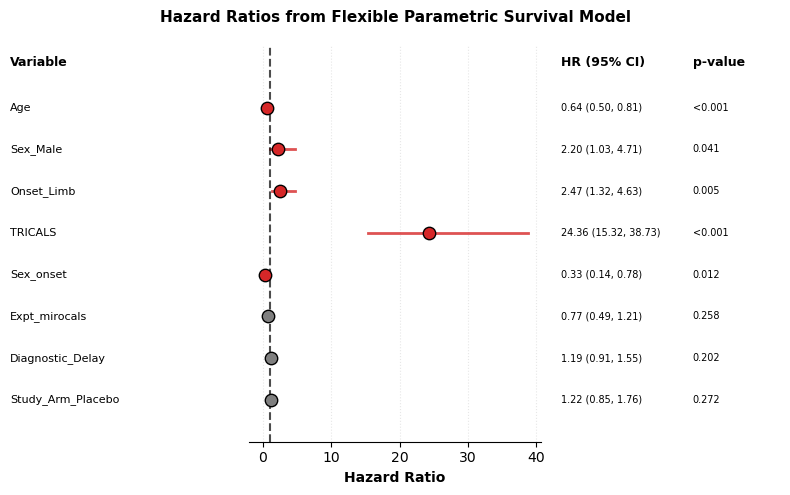

In [296]:
# %%writefile going_modular/forest_plot_fp_model_haz_scale.py
def forest_plot_fp_model_haz_scale(df_coef):
    # Create figure with subplots for labels and plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 5), 
                                        gridspec_kw={'width_ratios': [3, 4, 3]})

    y_positions = np.arange(len(df_coef))

    # Left panel - Variable names
    ax1.axis('off')
    ax1.text(0, len(df_coef), 'Variable', fontweight='bold', fontsize=9)
    for idx, var in enumerate(df_coef['Variable']):
        ax1.text(0, len(df_coef) - idx - 1, var, fontsize=8, va='center')
    ax1.set_ylim(-1, len(df_coef) + 0.5)

    # Middle panel - Forest plot
    for idx, row in df_coef.iterrows():
        y_pos = len(df_coef) - idx - 1
        color = '#d62728' if row['Significant'] else '#7f7f7f'
        
        # CI line
        ax2.plot([row['HR_lower'], row['HR_upper']], [y_pos, y_pos], 
                color=color, linewidth=2, alpha=0.8)
        
        # Point estimate
        ax2.scatter(row['HR'], y_pos, s=80, color=color, 
                zorder=3, edgecolors='black', linewidth=1)

    # Reference line
    ax2.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

    ax2.set_xlabel('Hazard Ratio', fontsize=10, fontweight='bold')
    ax2.set_yticks([])
    ax2.set_ylim(-1, len(df_coef) + 0.5)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)
    ax2.set_xlim(left=min(-2, df_coef['HR_lower'].min() - 0.5))

    # Right panel - HR values and p-values
    ax3.axis('off')
    ax3.text(0, len(df_coef), 'HR (95% CI)', fontweight='bold', fontsize=9)
    ax3.text(0.6, len(df_coef), 'p-value', fontweight='bold', fontsize=9)

    for idx, row in df_coef.iterrows():
        y_pos = len(df_coef) - idx - 1
        hr_text = f"{row['HR']:.2f} ({row['HR_lower']:.2f}, {row['HR_upper']:.2f})"
        p_text = f"{row['Pr(z)']:.3f}" if row['Pr(z)'] >= 0.001 else "<0.001"
        
        ax3.text(0, y_pos, hr_text, fontsize=7, va='center')
        ax3.text(0.6, y_pos, p_text, fontsize=7, va='center')

    ax3.set_ylim(-1, len(df_coef) + 0.5)

    plt.suptitle('Hazard Ratios from Flexible Parametric Survival Model', 
                fontsize=11, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

forest_plot_fp_model_haz_scale(extract_coefficients_from_fp_model_haz_scale(fp_model))

In [297]:
# train_df.columns = train_df.columns.str.replace(' ', '_')
# test_df.columns = test_df.columns.str.replace(' ', '_')
train_df.columns

Index(['subject_id', 'Expt_mirocals', 'Study_id', 'Study_Arm_Placebo', 'Age',
       'TRICALS', 'Diagnostic_Delay', 'Vital_capacity', 'Onset_Limb',
       'European_Yes', 'Sex_Male', 'Sex_onset', 'Age_Sex', 'Age_onset',
       'Age_TRICALS', 'Disease_Duration', 'Event'],
      dtype='object')

In [298]:
means = ["Age", "TRICALS", "Diagnostic_Delay"]
modes = ["Sex_Male", "Onset_Limb", "Study_Arm_Placebo", "Expt_mirocals", "Sex_onset"]

In [299]:
# %%writefile going_modular/make_newdata_for_fp_model_prediction.py
def make_newdata_for_fp_model_prediction(df, means, modes, time_col):
    times = np.linspace(0, df[time_col].max(), 100)

    n = len(times)

    values = {c: df[c].mean() for c in means}
    values.update({c: df[c].mode()[0] for c in modes})

    newdata_r = {}
    newdata_r.update({c: FloatVector([values[c]] * n) for c in means})
    newdata_r.update({c: IntVector([values[c]] * n) for c in modes})
    newdata_r[time_col] = FloatVector(times)

    with localconverter(default_converter + pandas2ri.converter):
        return DataFrame(newdata_r)

# newdata = make_newdata_for_fp_model_prediction(train_df, means, modes, 'Disease_Duration')
# newdata

In [300]:
# Prepare newdata for train and test
newdata_train = make_newdata_for_fp_model_prediction(train_df, means, modes, 'Disease_Duration')
newdata_test = make_newdata_for_fp_model_prediction(test_df, means, modes, 'Disease_Duration')

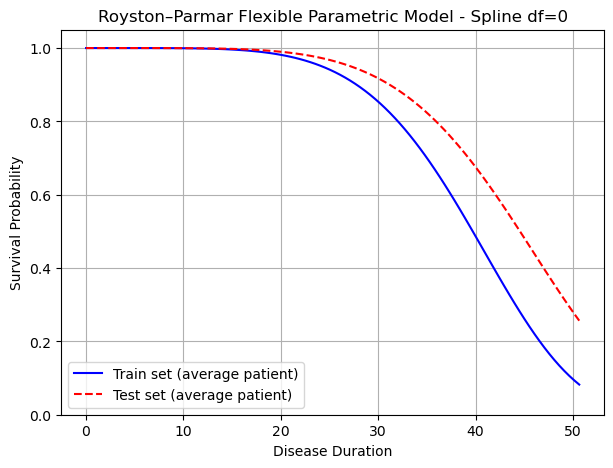

In [301]:
# %%writefile going_modular/prediction_survival_for_average_patient_fp_model_train_test.py
def prediction_survival_for_average_patient_fp_model_train_test(df, fp_model, newdata_train, newdata_test, time_col):
    # Predict survival probabilities using the fitted model
    r_predict = ro.r['predict']

    S_train = r_predict(fp_model, newdata=newdata_train, type="surv")
    S_test = r_predict(fp_model, newdata=newdata_test, type="surv")

    with localconverter(default_converter + pandas2ri.converter):
        py_S_train = np.array(S_train)
        py_S_test = np.array(S_test)

    # Plot
    times = np.linspace(0, df[time_col].max(), 100)
    plt.figure(figsize=(7,5))
    plt.plot(times, py_S_train, label="Train set (average patient)", color='blue')
    plt.plot(times, py_S_test, label="Test set (average patient)", color='red', linestyle='--')

    plt.xlabel("Disease Duration")
    plt.ylabel("Survival Probability")
    plt.ylim(0, 1.05)
    plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
    plt.legend()
    plt.grid(True)
    plt.show()

prediction_survival_for_average_patient_fp_model_train_test(df, fp_model, newdata_train, newdata_test, 'Disease_Duration')

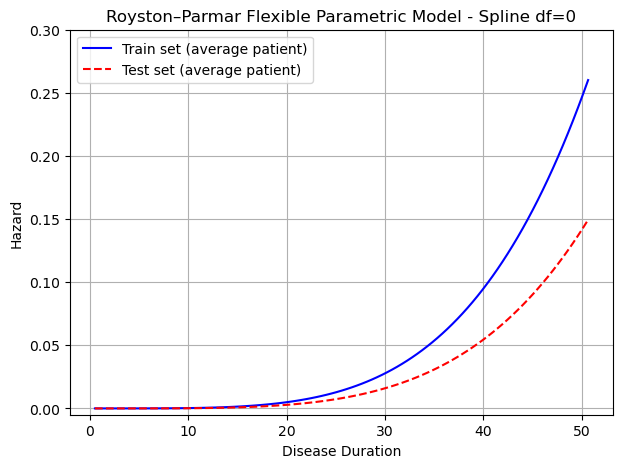

In [302]:
# %%writefile going_modular/prediction_hazard_for_average_patient_fp_model_train_test.py
def prediction_hazard_for_average_patient_fp_model_train_test(df, fp_model, newdata_train=None, newdata_test=None, time_col=None):
    # Predict survival probabilities using the fitted model
    r_predict = ro.r['predict']
    times = np.linspace(0, df[time_col].max(), 100)

    S_train = r_predict(fp_model, newdata=newdata_train, type="hazard")
    S_test = r_predict(fp_model, newdata=newdata_test, type="hazard")

    with localconverter(default_converter + pandas2ri.converter):
        py_S_train = np.array(S_train)
        py_S_test = np.array(S_test)

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(times, py_S_train, label="Train set (average patient)", color='blue')
    plt.plot(times, py_S_test, label="Test set (average patient)", color='red', linestyle='--')

    plt.xlabel("Disease Duration")
    plt.ylabel("Hazard")
    plt.ylim(-0.005, 0.3)
    plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
    plt.legend()
    plt.grid(True)
    plt.show()

prediction_hazard_for_average_patient_fp_model_train_test(df, fp_model, newdata_train=newdata_train, newdata_test=newdata_test, time_col='Disease_Duration')

In [303]:
# %%writefile going_modular/make_newdata_category_for_fp_model_prediction.py
def make_newdata_category_for_fp_model_prediction(df, means, modes, time_col, cat_col):
    times = np.linspace(0, df[time_col].max(), 100)

    n = len(times)

    values = {c: df[c].mean() for c in means}
    values.update({c: df[c].mode()[0] for c in modes})

    # Choose the two covariate levels you want to compare
    level0 = df[cat_col].unique()[0]
    level1 = df[cat_col].unique()[1]

    newdata_0 = {}
    newdata_0.update({c: FloatVector([values[c]] * n) for c in means})
    newdata_0.update({c: IntVector([values[c]] * n) for c in modes})
    newdata_0[cat_col] = IntVector([level0] * n)
    newdata_0[time_col] = FloatVector(times)

    newdata_1 = {}
    newdata_1.update({c: FloatVector([values[c]] * n) for c in means})
    newdata_1.update({c: IntVector([values[c]] * n) for c in modes})
    newdata_1[cat_col] = IntVector([level1] * n)
    newdata_1[time_col] = FloatVector(times)

    with localconverter(default_converter + pandas2ri.converter):
        return DataFrame(newdata_0), DataFrame(newdata_1)

In [304]:
newdata_0_train, newdata_1_train = make_newdata_category_for_fp_model_prediction(train_df, means, modes, time_col="Disease_Duration", cat_col='Expt_mirocals')
newdata_0_test, newdata_1_test = make_newdata_category_for_fp_model_prediction(test_df, means, modes, time_col="Disease_Duration", cat_col='Expt_mirocals')

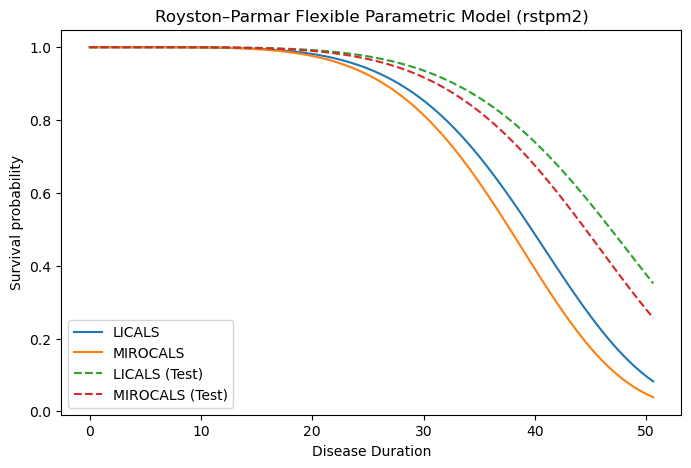

In [305]:
# %%writefile going_modular/prediction_survival_for_average_patient_cat_cov_fp_model_train_test.py
def prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df,
                                                                        fp_model,
                                                                        newdata_0_train=None,
                                                                        newdata_1_train=None,
                                                                        newdata_0_test=None,
                                                                        newdata_1_test=None,
                                                                        time_col=None,
                                                                        cat_col_0=None,
                                                                        cat_col_1=None):
    # Predict survival probabilities using the fitted model
    r_predict = ro.r['predict']
    times = np.linspace(0, df[time_col].max(), 100)

    S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
    S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

    S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
    S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

    with localconverter(default_converter + pandas2ri.converter):
        py_S0_train = np.array(S0_train)
        py_S1_train = np.array(S1_train)
        py_S0_test = np.array(S0_test)
        py_S1_test = np.array(S1_test)

    plt.figure(figsize=(8,5))
    plt.plot(times, py_S0_train, label=f"{cat_col_0}")
    plt.plot(times, py_S1_train, label=f"{cat_col_1}")
    plt.plot(times, py_S0_test, label=f"{cat_col_0} (Test)", linestyle='--')
    plt.plot(times, py_S1_test, label=f"{cat_col_1} (Test)", linestyle='--')
    plt.xlabel("Disease Duration")
    plt.ylabel("Survival probability")
    plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
    plt.legend()
    plt.show()

prediction_survival_for_average_patient_cat_cov_fp_model_train_test(df,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='LICALS',
                                                                    cat_col_1='MIROCALS')

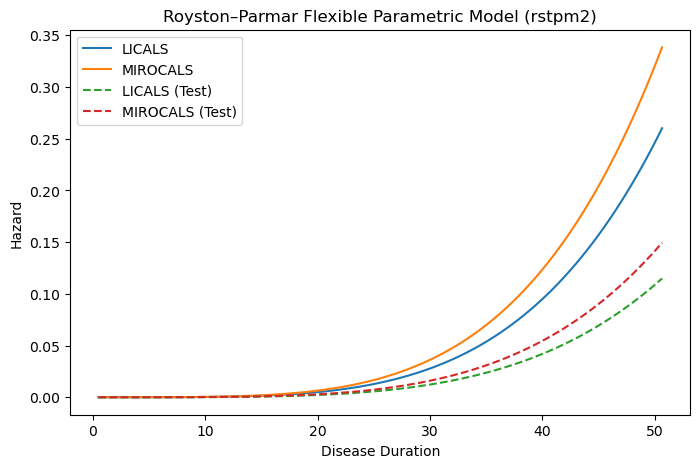

In [308]:
# %%writefile going_modular/prediction_hazard_for_average_patient_cat_cov_fp_model_train_test.py
def prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df,
                                                                        fp_model,
                                                                        newdata_0_train=None,
                                                                        newdata_1_train=None,
                                                                        newdata_0_test=None,
                                                                        newdata_1_test=None,
                                                                        time_col=None,
                                                                        cat_col_0=None,
                                                                        cat_col_1=None):
    # Predict survival probabilities using the fitted model
    r_predict = ro.r['predict']
    times = np.linspace(0, df[time_col].max(), 100)

    S0_train = r_predict(fp_model, newdata=newdata_0_train, type="hazard")
    S1_train = r_predict(fp_model, newdata=newdata_1_train, type="hazard")

    S0_test = r_predict(fp_model, newdata=newdata_0_test, type="hazard")
    S1_test = r_predict(fp_model, newdata=newdata_1_test, type="hazard")

    with localconverter(default_converter + pandas2ri.converter):
        py_S0_train = np.array(S0_train)
        py_S1_train = np.array(S1_train)
        py_S0_test = np.array(S0_test)
        py_S1_test = np.array(S1_test)

    #_______________________________________________________
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,5))
    plt.plot(times, py_S0_train, label=f"{cat_col_0}")
    plt.plot(times, py_S1_train, label=f"{cat_col_1}")
    plt.plot(times, py_S0_test, label=f"{cat_col_0} (Test)", linestyle='--')
    plt.plot(times, py_S1_test, label=f"{cat_col_1} (Test)", linestyle='--')
    plt.xlabel("Disease Duration")
    plt.ylabel("Hazard")
    plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
    plt.legend()
    plt.show()

prediction_hazard_for_average_patient_cat_cov_fp_model_train_test(df,
                                                                    fp_model,
                                                                    newdata_0_train=newdata_0_train,
                                                                    newdata_1_train=newdata_1_train,
                                                                    newdata_0_test=newdata_0_test,
                                                                    newdata_1_test=newdata_1_test,
                                                                    time_col='Disease_Duration',
                                                                    cat_col_0='LICALS',
                                                                    cat_col_1='MIROCALS')

In [ ]:
newdata_0_train, newdata_1_train = make_newdata_category(train_df, 'Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category(test_df, 'Study_Arm_Placebo')


# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

#_______________________________________________________
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


In [ ]:
# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="hazard")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="hazard")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="hazard")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

In [ ]:
# Perform likelihood ratio test between two models



## Prognostic Scores for Baseline Model (fit)

In [ ]:
# prognostic score (linear predictor) with standard error
r_predict = r['predict']

train_df["prognostic_score"] = r_predict(fp_model, type = "link")
# test_df["prognostic_score"] = r_predict(fp_model, type = "link")

train_df.head(3)

In [ ]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

In [ ]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [ ]:
print(f"{train_df.Event.value_counts() / train_df.Event.value_counts().sum()}\n")
print(f"{train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()}\n")
print(f"{train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()}\n")
print(f"{train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()}\n")
print(f"{train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()}\n")

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [ ]:
ons, sex

In [ ]:
df.head(3)

In [ ]:
df1.columns

In [ ]:
df1.head(3)

In [ ]:
corr = train_df[['Age', 'Expt_mirocals','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

In [ ]:
# from scipy.stats import norm

# def gaussian_copula_samples(n, corr):
#     """
#     Draw correlated U(0,1) samples using a Gaussian copula.
#     corr = correlation matrix (p x p).
#     Returns: U (n x p) matrix of uniforms.
#     """
#     L = np.linalg.cholesky(corr)
#     Z = np.random.normal(size=(n, corr.shape[0]))
#     Z_corr = Z @ L.T
#     U = norm.cdf(Z_corr)
#     return U



# def simulate_cox_dataset(n,baseline='weibull',lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        # Weibull inverse CDF: T = (-log U)^(1/rho) / (lam*exp(lp))^(1/rho)
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df

In [ ]:
df = df_coef
df

In [ ]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [ ]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Expt_mirocals', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [ ]:
def gaussian_copula_samples(n, corr):
    """
    Draw correlated U(0,1) samples using a Gaussian copula.
    corr = correlation matrix (p x p).
    Returns: U (n x p) matrix of uniforms.
    """
    L = np.linalg.cholesky(corr)
    Z = np.random.normal(size=(n, corr.shape[0]))
    Z_corr = Z @ L.T
    U = norm.cdf(Z_corr)
    return U


def estimate_baseline_cumhaz(original_df, time_col='time', event_col='event'):
    """
    Estimate baseline cumulative hazard from real data using Nelson–Aalen.
    """
    naf = NelsonAalenFitter()
    naf.fit(original_df[time_col], event_observed=original_df[event_col])

    H0 = naf.cumulative_hazard_.reset_index()
    H0.columns = ['time', 'cumhaz']
    return H0

H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

def sample_survival_times_from_empirical_baseline(U, H0_df, linpred):
    """
    Sample survival times using inverse cumulative hazard.

    U: uniform(0,1)
    H0_df: dataframe from estimate_baseline_cumhaz()
    linpred: linear predictor
    """

    # Effective cumulative hazard for each individual
    target = -np.log(U) / np.exp(linpred)

    # Interpolate to get survival times
    return np.interp(target, H0_df['cumhaz'], H0_df['time'])

def sample_survival_times_from_empirical_baseline(U, H0_df, linear_pred):
    """
    Inverse transform sampling using an empirical baseline cumulative hazard.
    """
    H0_t = H0_df["time"].values
    H0_vals = H0_df["cumhaz"].values

    v = -np.log(U) / np.exp(linear_pred)

    # Interpolate inverse of H0
    T = np.interp(v, H0_vals, H0_t, left=H0_t[0], right=H0_t[-1])
    return T

def simulate_cox_dataset_with_correlation(n,baseline='weibull', H0_df=None,lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == "empirical":
        if H0_df is None:
            raise ValueError("You must supply H0_df when using empirical baseline.")
        T = sample_survival_times_from_empirical_baseline(U_time, H0_df, linear_pred)

    elif baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))

    elif baseline == 'weibull':
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df



In [ ]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

In [ ]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [ ]:
sim_df.head(3)

In [ ]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

In [ ]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

In [ ]:
train_df.head(3)

In [ ]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [ ]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Sex_onset + Expt_mirocals + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
print(ro.r.summary(fp_model1))

In [ ]:
# Get coefficients directly
summary1 = ro.r.summary(fp_model1)

# Try using slotNames to see what's available
# print("Available slots:", ro.r.slotNames(summary))

# Extract using the correct slot name (usually 'coef' or 'coefficients')
coefficients1 = summary1.slots['coef']

# Convert to pandas DataFrame
df_coef1 = pd.DataFrame(
    np.array(coefficients1),
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
    index=list(coefficients1.rownames)
)

df_coef1 = df_coef1.iloc[1: -1]
df_coef1 = df_coef1.reset_index().rename(columns={"index": "Variable"})


print(df_coef1)

In [ ]:
df_coef

In [ ]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs

In [ ]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

In [ ]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(df1[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

In [ ]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(df1[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = df1[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model